## "Validating ICD-10 and Procedure Code Assignments Using NLP"

## **Objective:** This project aims to validate diagnosis and procedure code relationships using clinical data from MIMIC-IV v3.1. We apply four NLP techniques—ICD-10 Prefix Matching, Semantic Similarity with BERT, Named Entity Recognition (NER), and N-gram Analysis—to analyze and align high-risk ICD-10 codes.

## Load Data and Initial Setup of MIMIC IV Diagnosis and Procedure Codes

In [1]:
%%capture
!pip uninstall -y numpy scipy
!pip install numpy==1.26.0 scipy==1.11.3 gensim==4.3.2

In [15]:
%%capture
!pip install -U sentence-transformers
!pip install hf_xet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from gensim.models import KeyedVectors
from google.colab import drive
import gensim.downloader as api
import os

In [3]:
# Check contents of the folder
folder_path = '/content/drive/MyDrive/Project MIMIC IV'
for file in os.listdir(folder_path):
    print(file)

diagnoses_icd.csv
procedures_icd.csv
icd10pcs_codes_2025.txt
icd10cm_codes_2025.txt


In [4]:
import pandas as pd

path_to_csv1 = '/content/drive/MyDrive/Project MIMIC IV/diagnoses_icd.csv'
diagnoses_df = pd.read_csv(path_to_csv1)

path_to_csv2 = '/content/drive/MyDrive/Project MIMIC IV/procedures_icd.csv'
procedures_df = pd.read_csv(path_to_csv2)


# View first few rows
print(diagnoses_df.head())
print()
print(procedures_df.head())

   subject_id   hadm_id icd_code  icd_version  seq_num            admittime  \
0    11582633  25786218    Z8049           10       27  2144-10-31 17:30:00   
1    11968004  22808249    M5417           10       27  2146-12-25 21:31:00   
2    11968004  22808249     E669           10       28  2146-12-25 21:31:00   
3    11968004  22808249    Z6835           10       29  2146-12-25 21:31:00   
4    11968004  22808249     K219           10       30  2146-12-25 21:31:00   

             dischtime          admission_type admission_location  \
0  2144-11-01 16:48:00  AMBULATORY OBSERVATION     PROCEDURE SITE   
1  2146-12-26 18:25:00  AMBULATORY OBSERVATION               PACU   
2  2146-12-26 18:25:00  AMBULATORY OBSERVATION               PACU   
3  2146-12-26 18:25:00  AMBULATORY OBSERVATION               PACU   
4  2146-12-26 18:25:00  AMBULATORY OBSERVATION               PACU   

  discharge_location insurance                    race marital_status  
0                NaN  Medicare  BLACK/

## Data Cleaning and Formatting

In [5]:
# 1. Remove any duplicates
diagnoses_df.drop_duplicates(inplace=True)
procedures_df.drop_duplicates(inplace=True)

# 2. Standardize and clean ICD codes
def clean_icd_code(code):
    if isinstance(code, str):
        return code.replace(".", "").strip().upper()
    return code

diagnoses_df["icd_code"] = diagnoses_df["icd_code"].apply(clean_icd_code)
procedures_df["icd_code"] = procedures_df["icd_code"].apply(clean_icd_code)

# 3. Check shape
print("Diagnoses shape:", diagnoses_df.shape)
print("Procedures shape:", procedures_df.shape)

# Optional: view a few rows to verify
print("\nCleaned Diagnoses Sample:\n", diagnoses_df["icd_code"].head())
print("\nCleaned Procedures Sample:\n", procedures_df["icd_code"].head())

Diagnoses shape: (3455747, 13)
Procedures shape: (390446, 13)

Cleaned Diagnoses Sample:
 0    Z8049
1    M5417
2     E669
3    Z6835
4     K219
Name: icd_code, dtype: object

Cleaned Procedures Sample:
 0    00160J6
1    00160J6
2    00160J6
3    00160J6
4    00160J6
Name: icd_code, dtype: object


## Define High-Risk Diagnoses and Procedures

In [6]:
high_risk_diagnoses = [
    "A419",   # Sepsis
    "I213",   # Acute Myocardial Infarction
    "J189",   # Pneumonia, unspecified
    "I639"    # Stroke, unspecified
]


high_risk_procedures = [
    "021009W",  # CABG
    "0SRD0J9",  # Knee replacement
    "0DTJ4ZZ",  # Appendectomy
    "5A1221Z",  # Mechanical Ventilation
    "5A1D70Z",  # Hemodialysis
    "0D160Z3",  # Colon Resection
    "0W9G3ZZ"   # Drainage of body cavity
]

## Filtering the DataFrames

In [7]:
# Filter diagnoses
filtered_diagnoses_df = diagnoses_df[diagnoses_df["icd_code"].isin(high_risk_diagnoses)]

# Filter procedures
filtered_procedures_df = procedures_df[procedures_df["icd_code"].isin(high_risk_procedures)]

# Output the shapes
print("Filtered Diagnoses Shape:", filtered_diagnoses_df.shape)
print("Filtered Procedures Shape:", filtered_procedures_df.shape)

# Display first few rows
print("\nFiltered Diagnoses Sample:\n", filtered_diagnoses_df.head())
print("\nFiltered Procedures Sample:\n", filtered_procedures_df.head())

Filtered Diagnoses Shape: (18507, 13)
Filtered Procedures Shape: (17247, 13)

Filtered Diagnoses Sample:
        subject_id   hadm_id icd_code  icd_version  seq_num  \
3462     18535322  29633191     J189           10        4   
13781    10063460  27699140     A419           10        1   
13811    10127469  21644595     A419           10        1   
13836    10160622  21082262     A419           10        1   
13855    10177348  21976241     A419           10        1   

                 admittime            dischtime          admission_type  \
3462   2160-10-09 14:27:00  2160-10-10 19:15:00  AMBULATORY OBSERVATION   
13781  2175-01-05 17:06:00  2175-01-23 20:25:00            DIRECT EMER.   
13811  2162-09-18 17:24:00  2162-10-10 14:55:00            DIRECT EMER.   
13836  2180-04-21 09:55:00  2180-05-13 18:14:00            DIRECT EMER.   
13855  2179-11-08 18:35:00  2179-11-17 02:45:00            DIRECT EMER.   

       admission_location        discharge_location insurance  \
3462 

## Known Diagnosis–Procedure Pairs

In [8]:
print("Top ICD Prefixes in Diagnoses:")
print(filtered_diagnoses_df["icd_code"].str.replace(".", "", regex=False).str[:3].value_counts().head(10))

print("\nTop ICD Prefixes in Procedures:")
print(filtered_procedures_df["icd_code"].str.replace(".", "", regex=False).str[:3].value_counts().head(10))

Top ICD Prefixes in Diagnoses:
icd_code
J18    9415
A41    7770
I63    1078
I21     244
Name: count, dtype: int64

Top ICD Prefixes in Procedures:
icd_code
5A1    10325
0W9     5202
021      752
0SR      688
0DT      280
Name: count, dtype: int64


## Visualization 1: Top ICD-10 Prefix Matching Bar graph

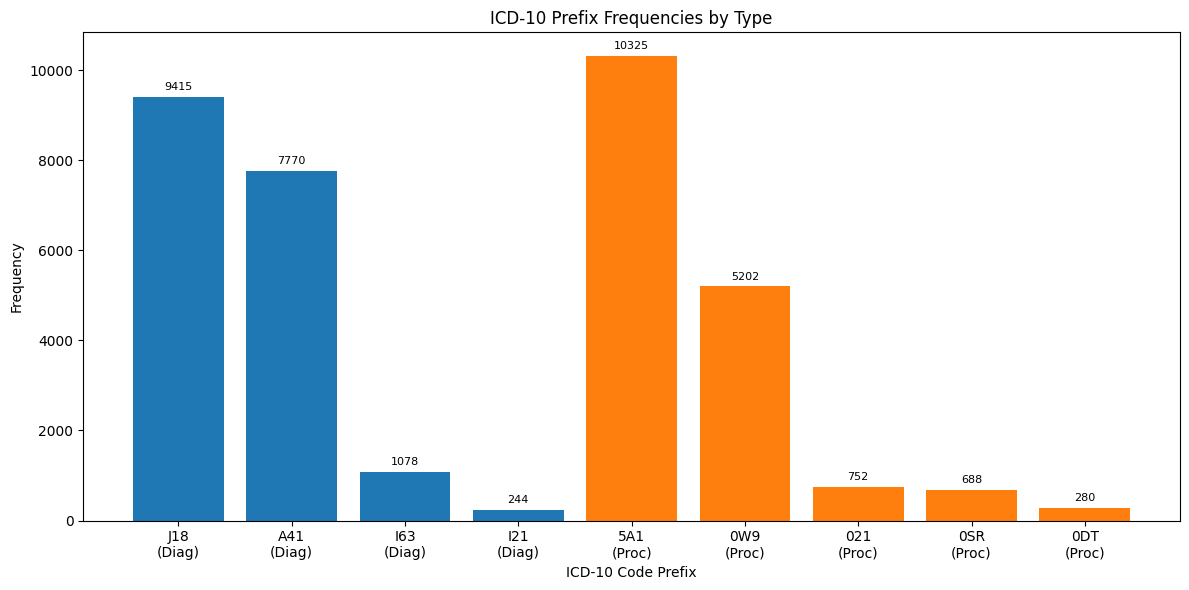

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Original data
diagnosis_prefix_counts = {
    'J18': 9415,
    'A41': 7770,
    'I63': 1078,
    'I21': 244
}

procedure_prefix_counts = {
    '5A1': 10325,
    '0W9': 5202,
    '021': 752,
    '0SR': 688,
    '0DT': 280
}

# Create separate dataframes
diag_df = pd.DataFrame(list(diagnosis_prefix_counts.items()), columns=["Prefix", "Count"])
diag_df["Type"] = "Diagnoses"

proc_df = pd.DataFrame(list(procedure_prefix_counts.items()), columns=["Prefix", "Count"])
proc_df["Type"] = "Procedures"

# Combine and sort
combined_df = pd.concat([diag_df, proc_df], ignore_index=True)

# Create a combined label for each bar (to use as x-axis tick)
combined_df["Label"] = combined_df["Prefix"] + "\n(" + combined_df["Type"].str[:4] + ")"

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(combined_df["Label"], combined_df["Count"], color=["tab:blue" if t == "Diagnoses" else "tab:orange" for t in combined_df["Type"]])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{int(height)}', ha='center', va='bottom', fontsize=8)

# Styling
plt.xlabel("ICD-10 Code Prefix")
plt.ylabel("Frequency")
plt.title("ICD-10 Prefix Frequencies by Type")
plt.tight_layout()
plt.show()


## Technique 1: ICD-10 Prefix Matching (Information Extraction)

## Filter Matching Diagnosis–Procedure Pairs

In [10]:
filtered_diagnoses_clean = filtered_diagnoses_df.copy()
filtered_procedures_clean = filtered_procedures_df.copy()

# Normalize ICD codes (remove dots)
filtered_diagnoses_clean["clean_icd"] = filtered_diagnoses_clean["icd_code"].str.replace(".", "", regex=False)
filtered_procedures_clean["clean_icd"] = filtered_procedures_clean["icd_code"].str.replace(".", "", regex=False)

# Merge diagnoses and procedures on subject_id and hadm_id
merged_df = pd.merge(
    filtered_diagnoses_clean[["subject_id", "hadm_id", "clean_icd"]],
    filtered_procedures_clean[["subject_id", "hadm_id", "clean_icd"]],
    on=["subject_id", "hadm_id"],
    suffixes=("_dx", "_px")
)

# Sample diagnosis-to-procedure code mappings
icd_mappings = {
    "I213": ["021009W", "0SRD0J9"],     # AMI → CABG or heart surgery
    "I63": ["03CG3ZZ"],                 # Stroke → Thrombectomy
    "J189": ["5A1955Z"],                # Pneumonia → Mechanical Ventilation
    "A419": ["0DTJ4ZZ", "5A1221Z"],     # Sepsis → Central Line, Continuous ventilation
}

# Function to validate mapping
def is_valid_pair(row):
    return row["clean_icd_dx"] in icd_mappings and row["clean_icd_px"] in icd_mappings[row["clean_icd_dx"]]

# Apply validation
merged_df["valid_mapping"] = merged_df.apply(is_valid_pair, axis=1)

# Filter to only valid pairs
valid_pairs_df = merged_df[merged_df["valid_mapping"] == True]

# Output
print("Sample Valid ICD Code Mappings:\n", valid_pairs_df.head())
print("Total Valid Matches Found:", valid_pairs_df.shape[0])

Sample Valid ICD Code Mappings:
      subject_id   hadm_id clean_icd_dx clean_icd_px  valid_mapping
2      11749987  22053731         I213      021009W           True
30     11721074  27570992         A419      5A1221Z           True
66     12864445  22385273         A419      5A1221Z           True
86     16123216  21307155         A419      5A1221Z           True
104    14028670  23763603         A419      5A1221Z           True
Total Valid Matches Found: 105


## Visualization 2: Bar graph of ICD-10 Diagnosis and Procedure Frequency mapping

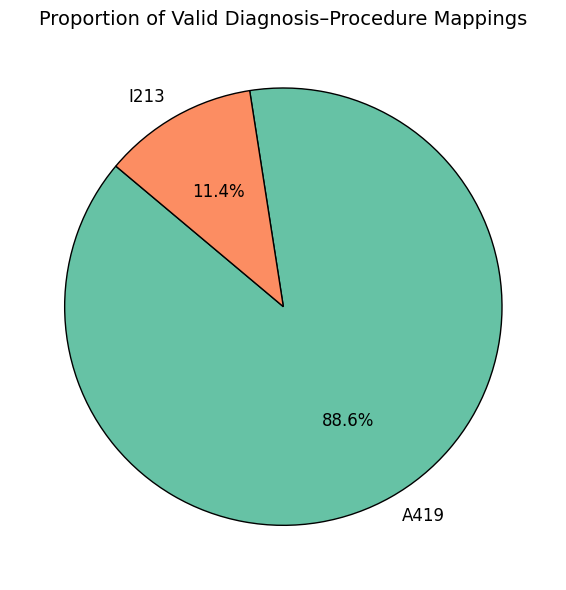

In [11]:
import matplotlib.pyplot as plt

# Count frequencies by diagnosis code
dx_counts = valid_pairs_df["clean_icd_dx"].value_counts().reset_index()
dx_counts.columns = ["Diagnosis Code", "Frequency"]

# Define custom colors (light and varied for visual clarity)
custom_colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"]

# Pie chart with better aesthetics
plt.figure(figsize=(8, 6))
patches, texts, autotexts = plt.pie(
    dx_counts["Frequency"],
    labels=dx_counts["Diagnosis Code"],
    autopct='%1.1f%%',
    startangle=140,
    colors=custom_colors[:len(dx_counts)],
    wedgeprops={'edgecolor': 'black'}
)

# Make labels and percentages more readable
for text in texts:
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')

plt.title("Proportion of Valid Diagnosis–Procedure Mappings", fontsize=14)
plt.tight_layout()
plt.show()

## Loading the list of ICD-10 CM & PCS Codes with description from CMS

In [12]:
# Loading CMS ICD-10 CM & PCS Complete List of Codes and Descriptions
with open('/content/drive/MyDrive/Project MIMIC IV/icd10cm_codes_2025.txt', 'r') as f:
    cm_lines = f.readlines()

with open('/content/drive/MyDrive/Project MIMIC IV/icd10pcs_codes_2025.txt', 'r') as f:
    pcs_lines = f.readlines()

# Split based on the first space (you can adjust if needed)
cm_data = [line.strip().split(None, 1) for line in cm_lines if line.strip()]
pcs_data = [line.strip().split(None, 1) for line in pcs_lines if line.strip()]

# Convert to DataFrame
cm_df = pd.DataFrame(cm_data, columns=['icd_code', 'description'])
pcs_df = pd.DataFrame(pcs_data, columns=['icd_code', 'description'])

# View samples
print("CM Sample:")
print(cm_df.head())

print("\nPCS Sample:")
print(pcs_df.head())

CM Sample:
  icd_code                                        description
0     A000  Cholera due to Vibrio cholerae 01, biovar chol...
1     A001    Cholera due to Vibrio cholerae 01, biovar eltor
2     A009                               Cholera, unspecified
3    A0100                         Typhoid fever, unspecified
4    A0101                                 Typhoid meningitis

PCS Sample:
  icd_code                                        description
0  0016070  Bypass Cerebral Ventricle to Nasopharynx with ...
1  0016071  Bypass Cerebral Ventricle to Mastoid Sinus wit...
2  0016072  Bypass Cerebral Ventricle to Atrium with Autol...
3  0016073  Bypass Cerebral Ventricle to Blood Vessel with...
4  0016074  Bypass Cerebral Ventricle to Pleural Cavity wi...


## Cosine similarity Top 3 Matches for High-risk diagnoses

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Filter only relevant diagnoses from the previously gathered sample
query_codes = ['A419', 'I213', 'J189', 'I639']  # Sepsis, AMI, Pneumonia, Stroke
query_df = cm_df[cm_df['icd_code'].isin(query_codes)]

# Prepare corpus
corpus = pcs_df['description'].tolist()
queries = query_df['description'].tolist()

# Fit TF-IDF vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus + queries)

# Separate embeddings
pcs_tfidf = tfidf_matrix[:len(corpus)]
query_tfidf = tfidf_matrix[len(corpus):]

# Calculate similarities
similarities = cosine_similarity(query_tfidf, pcs_tfidf)

# Display top 3 matches for each query
for i, code in enumerate(query_codes):
    print(f"\nTop 3 Procedure Matches for Diagnosis '{code}':")
    top_indices = similarities[i].argsort()[-3:][::-1]
    for rank, idx in enumerate(top_indices, 1):
        print(f"{rank}. {pcs_df.iloc[idx]['icd_code']}: {pcs_df.iloc[idx]['description']}")


Top 3 Procedure Matches for Diagnosis 'A419':
1. 30233G4: Transfusion of Allogeneic Unspecified Bone Marrow into Peripheral Vein, Percutaneous Approach
2. 30243G4: Transfusion of Allogeneic Unspecified Bone Marrow into Central Vein, Percutaneous Approach
3. 30233Y4: Transfusion of Allogeneic Unspecified Hematopoietic Stem Cells into Peripheral Vein, Percutaneous Approach

Top 3 Procedure Matches for Diagnosis 'I213':
1. 02RH38M: Replacement of Pulmonary Valve with Zooplastic Tissue, Native Site, Percutaneous Approach
2. 30233G4: Transfusion of Allogeneic Unspecified Bone Marrow into Peripheral Vein, Percutaneous Approach
3. 30243G4: Transfusion of Allogeneic Unspecified Bone Marrow into Central Vein, Percutaneous Approach

Top 3 Procedure Matches for Diagnosis 'J189':
1. 30233G4: Transfusion of Allogeneic Unspecified Bone Marrow into Peripheral Vein, Percutaneous Approach
2. 30243G4: Transfusion of Allogeneic Unspecified Bone Marrow into Central Vein, Percutaneous Approach
3. 00163ZB:

In [14]:
# Filter PCS descriptions to relevant ones only
keywords = ['cardiac', 'heart', 'bypass', 'lung', 'respiratory', 'brain', 'stroke', 'ventilation', 'intubation', 'infection']
pcs_relevant_df = pcs_df[pcs_df['description'].str.lower().str.contains('|'.join(keywords))]

# Re-run the TF-IDF logic
corpus = pcs_relevant_df['description'].tolist()
queries = query_df['description'].tolist()

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus + queries)

pcs_tfidf = tfidf_matrix[:len(corpus)]
query_tfidf = tfidf_matrix[len(corpus):]

similarities = cosine_similarity(query_tfidf, pcs_tfidf)

# Show improved results
for i, code in enumerate(query_codes):
    print(f"\nTop 3 Procedure Matches for Diagnosis '{code}':")
    top_indices = similarities[i].argsort()[-3:][::-1]
    for rank, idx in enumerate(top_indices, 1):
        print(f"{rank}. {pcs_relevant_df.iloc[idx]['icd_code']}: {pcs_relevant_df.iloc[idx]['description']}")



Top 3 Procedure Matches for Diagnosis 'A419':
1. XXE5XN6: Measurement of Infection, Positive Blood Culture Fluorescence Hybridization for Organism Identification, Concentration and Susceptibility, New Technology Group 6
2. XXEBXQ6: Measurement of Infection, Lower Respiratory Fluid Nucleic Acid-base Microbial Detection, New Technology Group 6
3. 041D4AH: Bypass Left Common Iliac Artery to Right Femoral Artery with Autologous Arterial Tissue, Percutaneous Endoscopic Approach

Top 3 Procedure Matches for Diagnosis 'I213':
1. 0B9K0ZZ: Drainage of Right Lung, Open Approach
2. 0B9L0ZZ: Drainage of Left Lung, Open Approach
3. 0B9K3ZZ: Drainage of Right Lung, Percutaneous Approach

Top 3 Procedure Matches for Diagnosis 'J189':
1. 00160ZB: Bypass Cerebral Ventricle to Cerebral Cisterns, Open Approach
2. 00163ZB: Bypass Cerebral Ventricle to Cerebral Cisterns, Percutaneous Approach
3. 00164ZB: Bypass Cerebral Ventricle to Cerebral Cisterns, Percutaneous Endoscopic Approach

Top 3 Procedure Matc

## Technique 2: Semantic Similarity using Word2Vec and Clinical Sentence Transformer

## Word2Vec Google model

In [16]:
# Load the model from Drive
model = KeyedVectors.load("/content/drive/MyDrive/word2vec_google_news.model")

In [17]:
import numpy as np
from nltk.tokenize import word_tokenize

In [18]:
import nltk

def get_sentence_vector(sentence, model):
    words = word_tokenize(sentence.lower())
    word_vectors = []

    for word in words:
        if word in model:
            word_vectors.append(model[word])

    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(300)  # Word2Vec vector size is 300

In [19]:
high_risk_diag_codes = ["A419", "I213", "J189", "I639"] # Sepsis, AMI, Pneumonia, Stroke
cm_subset = cm_df[cm_df['icd_code'].isin(high_risk_diag_codes)]

diagnosis_desc = cm_subset["description"].tolist()
diagnosis_codes = cm_subset["icd_code"].tolist()

procedure_codes = pcs_df["icd_code"].tolist()
procedure_desc = pcs_df["description"].tolist()

In [20]:
diagnosis_subset = cm_df[cm_df['icd_code'].isin(['A419', 'I213', 'J189', 'I639'])].copy()
procedure_subset = pcs_df.copy()

diagnosis_subset.reset_index(drop=True, inplace=True)
procedure_subset.reset_index(drop=True, inplace=True)

print("Diagnoses:\n", diagnosis_subset.head())
print("Procedures:\n", procedure_subset.head())

Diagnoses:
   icd_code                                        description
0     A419                       Sepsis, unspecified organism
1     I213  ST elevation (STEMI) myocardial infarction of ...
2     I639                   Cerebral infarction, unspecified
3     J189                    Pneumonia, unspecified organism
Procedures:
   icd_code                                        description
0  0016070  Bypass Cerebral Ventricle to Nasopharynx with ...
1  0016071  Bypass Cerebral Ventricle to Mastoid Sinus wit...
2  0016072  Bypass Cerebral Ventricle to Atrium with Autol...
3  0016073  Bypass Cerebral Ventricle to Blood Vessel with...
4  0016074  Bypass Cerebral Ventricle to Pleural Cavity wi...


In [21]:
nltk.download('punkt_tab')

for code, diag in zip(diagnosis_codes, diagnosis_desc):
    diag_vec = get_sentence_vector(diag, model)
    similarities = []

    for proc_code, proc in zip(procedure_codes, procedure_desc):
        proc_vec = get_sentence_vector(proc, model)
        score = cosine_similarity([diag_vec], [proc_vec])[0][0]
        similarities.append((proc_code, proc, score))

    top_matches = sorted(similarities, key=lambda x: x[2], reverse=True)[:3]
    print(f"\nTop 3 Procedure Matches for Diagnosis '{code}':")
    for match in top_matches:
        print(f"{match[0]}: {match[1]} (Score: {match[2]:.4f})")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Top 3 Procedure Matches for Diagnosis 'A419':
XXEBXQ6: Measurement of Infection, Lower Respiratory Fluid Nucleic Acid-base Microbial Detection, New Technology Group 6 (Score: 0.5947)
30243Y4: Transfusion of Allogeneic Unspecified Hematopoietic Stem Cells into Central Vein, Percutaneous Approach (Score: 0.5892)
XXE5XN6: Measurement of Infection, Positive Blood Culture Fluorescence Hybridization for Organism Identification, Concentration and Susceptibility, New Technology Group 6 (Score: 0.5851)

Top 3 Procedure Matches for Diagnosis 'I213':
B446ZZ3: Ultrasonography of Right Renal Artery, Intravascular (Score: 0.6317)
B447ZZ3: Ultrasonography of Left Renal Artery, Intravascular (Score: 0.6309)
3E0J8U1: Introduction of Nonautologous Pancreatic Islet Cells into Biliary and Pancreatic Tract, Via Natural or Artificial Opening Endoscopic (Score: 0.6209)

Top 3 Procedure Matches for Diagnosis 'I639':
00163ZB: Bypass Cerebral Ventricle to Cerebral Cisterns, Percutaneous Approach (Score: 0.6172

## Model from Hugging Face

In [34]:
from sentence_transformers import SentenceTransformer
import pandas as pd


model = SentenceTransformer("Shobhank-iiitdwd/Clinical_sentence_transformers_mpnet_base_v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [35]:
sample_sentences = ["Sepsis diagnosis", "Blood infection treatment procedure"]
embeddings = model.encode(sample_sentences)
print("Embedding shape:", embeddings.shape)

Embedding shape: (2, 768)


In [36]:
# Step 1: Keep diagnosis embeddings as-is (small in size)
diagnosis_embeddings = model.encode(diagnosis_subset['description'].tolist())

# Step 2: Sample 500 procedure descriptions and embed them
sampled_procs = pcs_df.sample(n=500, random_state=42).reset_index(drop=True)
procedure_desc = sampled_procs['description'].tolist()
procedure_codes = sampled_procs['icd_code'].tolist()

procedure_embeddings = model.encode(procedure_desc)
print("Sampled Procedure Embeddings shape:", procedure_embeddings.shape)

# Compare using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

for idx, (diag_code, diag_desc) in diagnosis_subset.iterrows():
    diag_embedding = diagnosis_embeddings[idx].reshape(1, -1)

    scores = cosine_similarity(diag_embedding, procedure_embeddings)[0]
    top_indices = np.argsort(scores)[-3:][::-1]  # Top 3 indices

    print(f"\nTop 3 Procedure Matches for Diagnosis '{diag_code}':")
    for i in top_indices:
        print(f"{procedure_codes[i]}: {procedure_desc[i]} (Score: {scores[i]:.4f})")

Sampled Procedure Embeddings shape: (500, 768)

Top 3 Procedure Matches for Diagnosis 'A419':
047F47Z: Dilation of Left Internal Iliac Artery with Four or More Drug-eluting Intraluminal Devices, Percutaneous Endoscopic Approach (Score: 0.9180)
0GT34ZZ: Resection of Right Adrenal Gland, Percutaneous Endoscopic Approach (Score: 0.9180)
015C4ZZ: Destruction of Pudendal Nerve, Percutaneous Endoscopic Approach (Score: 0.9155)

Top 3 Procedure Matches for Diagnosis 'I213':
B41B1ZZ: Fluoroscopy of Other Intra-Abdominal Arteries using Low Osmolar Contrast (Score: 0.9449)
02PA3JZ: Removal of Synthetic Substitute from Heart, Percutaneous Approach (Score: 0.9410)
02L70DK: Occlusion of Left Atrial Appendage with Intraluminal Device, Open Approach (Score: 0.9341)

Top 3 Procedure Matches for Diagnosis 'I639':
0GT34ZZ: Resection of Right Adrenal Gland, Percutaneous Endoscopic Approach (Score: 0.8640)
015C4ZZ: Destruction of Pudendal Nerve, Percutaneous Endoscopic Approach (Score: 0.8615)
047F47Z: Di

## Visualization 3: Semantic Similarity Heatmap

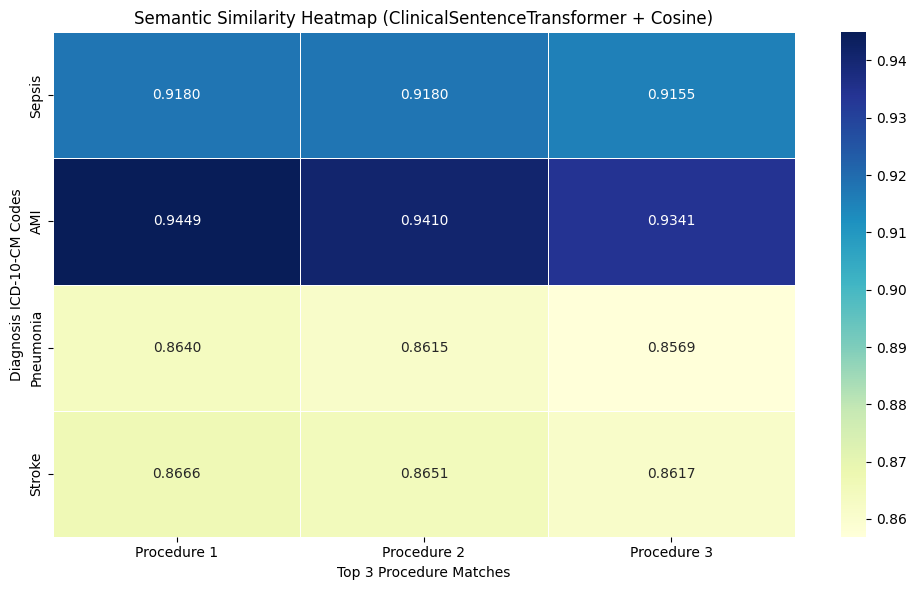

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Sample similarity scores from Technique 2
similarity_data = {
    'Diagnosis': ['Sepsis', 'AMI', 'Pneumonia', 'Stroke'],
    'Procedure 1': [0.9180, 0.9449, 0.8640, 0.8666],
    'Procedure 2': [0.9180, 0.9410, 0.8615, 0.8651],
    'Procedure 3': [0.9155, 0.9341, 0.8569, 0.8617]
}

similarity_df = pd.DataFrame(similarity_data)
similarity_df.set_index('Diagnosis', inplace=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(similarity_df, annot=True, cmap="YlGnBu", fmt=".4f", linewidths=.5)
plt.title("Semantic Similarity Heatmap (ClinicalSentenceTransformer + Cosine)")
plt.ylabel("Diagnosis ICD-10-CM Codes")
plt.xlabel("Top 3 Procedure Matches")
plt.tight_layout()
plt.show()

## Technique 3: Named Entity Recognition (NER) using SciSpaCy

In [26]:
%%capture
# Install scispacy
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_md-0.5.3.tar.gz

In [27]:
import spacy
import scispacy
from sklearn.model_selection import train_test_split

# Load ICD-10-CM descriptions
icd_cm_df = cm_df.dropna().reset_index(drop=True)  # Drop any rows with missing descriptions

# Train/Test split
train_df, test_df = train_test_split(icd_cm_df, test_size=0.3, random_state=42)

# Load SciSpaCy model
nlp = spacy.load("en_core_sci_md")

/usr/local/lib/python3.11/dist-packages/spacy/language.py:2141: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [28]:
# Apply NER to a sample of 10 diagnosis descriptions from the test set
sample_descriptions = test_df['description'].sample(n=10, random_state=42).tolist()

for i, desc in enumerate(sample_descriptions, 1):
    doc = nlp(desc)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    print(f"\n{i}. Description: {desc}")
    print("   Named Entities:", entities if entities else "None")


1. Description: Poisoning by antimycobacterial drugs, undetermined, subsequent encounter
   Named Entities: [('Poisoning', 'ENTITY'), ('antimycobacterial drugs', 'ENTITY')]

2. Description: Non-pressure chronic ulcer of other part of unspecified foot with fat layer exposed
   Named Entities: [('Non-pressure', 'ENTITY'), ('chronic ulcer', 'ENTITY'), ('unspecified', 'ENTITY'), ('foot with', 'ENTITY'), ('fat layer', 'ENTITY')]

3. Description: Flat anterior chamber hypotony of unspecified eye
   Named Entities: [('Flat anterior chamber hypotony', 'ENTITY')]

4. Description: Other extraarticular fracture of lower end of left radius, subsequent encounter for open fracture type I or II with routine healing
   Named Entities: [('extraarticular fracture', 'ENTITY'), ('left radius', 'ENTITY'), ('open fracture type I', 'ENTITY'), ('II', 'ENTITY'), ('routine healing', 'ENTITY')]

5. Description: Nondisplaced comminuted fracture of shaft of unspecified tibia, subsequent encounter for open fractur

## Technique 4: Bigram Frequency Analysis (N-gram)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [30]:
# Drop NaN and reset index
cm_cleaned = cm_df.dropna().reset_index(drop=True)

# Use only the description column
text_data = cm_cleaned['description'].tolist()

In [31]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(text_data)

# Sum up the counts of each bigram
sum_words = X.sum(axis=0)
bigram_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

In [32]:
print("Top 10 Bigrams in ICD-10-CM Descriptions:\n")
for phrase, freq in bigram_freq[:10]:
    print(f"{phrase}: {freq}")

Top 10 Bigrams in ICD-10-CM Descriptions:

subsequent encounter: 22121
initial encounter: 14503
encounter open: 6162
open fracture: 6162
encounter fracture: 5853
fracture type: 5100
encounter closed: 3831
closed fracture: 3831
fracture shaft: 3410
routine healing: 3033


## Visualization 4: Bigrams Horizontal Bar Graph

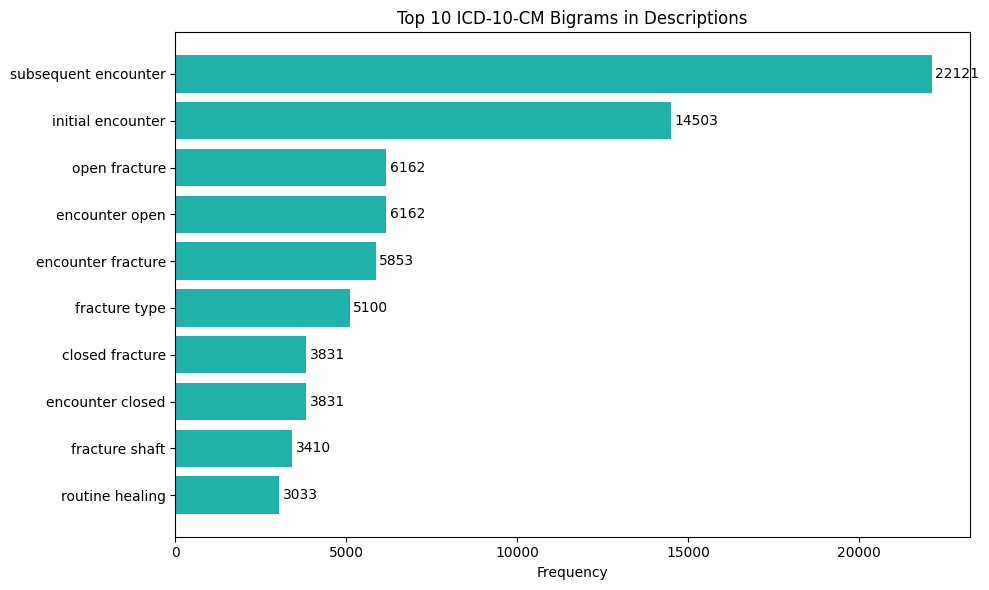

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Reuse your top 10 bigrams and counts
top_bigrams = bigram_freq[:10]
bigram_df = pd.DataFrame(top_bigrams, columns=["bigram", "count"])
bigram_df = bigram_df.sort_values(by="count", ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(bigram_df["bigram"], bigram_df["count"], color="lightseagreen")

# Add count labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 100, bar.get_y() + bar.get_height()/2,
             f'{int(width)}', va='center')

plt.xlabel("Frequency")
plt.title("Top 10 ICD-10-CM Bigrams in Descriptions")
plt.tight_layout()
plt.show()